# Assignment 4

**Due to**: TBD

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Fact checking, Neural Languange Inference (**NLI**)

# Intro

This assignment is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In particular, we will see:

*   Dataset preparation (analysis and pre-processing)
*   Problem formulation: multi-input binary classification
*   Defining an evaluation method
*   Simple sentence embedding
*   Neural building blocks
*   Neural architecture extension

# The FEVER dataset

First of all, we need to choose a dataset. In this assignment we will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}

---

**Not Verifiable**

{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}

---

## Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

In [1]:
import re
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from scipy.spatial import distance
plt.style.use('ggplot')

In [2]:
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


In [3]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
# reading our datasets
train = pd.read_csv("dataset/train_pairs.csv",index_col=0) 
val = pd.read_csv("dataset/val_pairs.csv",index_col=0) 
test = pd.read_csv("dataset/test_pairs.csv",index_col=0) 


In [5]:
train.head()

,Claim,Evidence,ID,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


The build a prepocess pipeline by removing useless information

In [6]:
# Here we are cleaning the data to be processed

import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

#Removing Non-English Words
try:
    STOPWORDS = set(stopwords.words('english')) 
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def lower(text):
    
    #Converting All Text to Lower Case Characters

    return text.lower()

def replace_special_characters(text):

    # Replaces Special Characters like Ampersand , Parenthesis , etc with Spacing Character    

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text):
  
   # Removes any Special Special Characters that is not a Good Symbol under Regular Expression 

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text):

    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def remove_extra_spaces(text):

   # Removes Unwanted Spacing Character's (Left and Right) from the Text 
   
    return re.sub('\s+',' ',text)

def strip_text(text):

   #Removes both the leading and the trailing characters based on the string argument passed.

    return text.strip()

def remove_starting_index(text):

  #Removes Unwanted Numbers from the Starting Index.
    
    return re.sub('^[0-9]+\t', '', text)

def remove_pronunciation(text):

  #Removes Unwanted Text (Pronunciation's) when it comes between LSB and RSB.
    
    return re.sub('-LSB- .* -RSB- ', '', text)

NLTK_SYM = re.compile('\-[A-Z]{3}\-')

def remove_NLTK_sym(text):
   
  #Removes NLTK special tokens, eg. LRB (Left Round Bracket) and RRB (Right Round Brackets) .

    return NLTK_SYM.sub('', text)

def remove_tabs(text):
   
   #Removes Unwanted Tab Character in Text 
   
    return re.sub('\t',' ', text)

def flatten(L):
  res = []
  for x in L:
    if isinstance(x, list):
      res += flatten(x)
    else:
      res.append(x)
  return res


def Token(txt):
  return [line.split() for line in txt]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
PREPROCESSING_PIPELINE = [
                          remove_starting_index,
                          remove_pronunciation,
                          remove_NLTK_sym,
                          lower,
                          replace_special_characters,
                          remove_extra_spaces,
                          remove_tabs,
                          strip_text
                          ]


#Using Anchor method to Filter the Text using the pre-processing pipeline sequence as given above

def text_prepare(text, reduce_methods=None):
    
    reduce_methods = reduce_methods if reduce_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), reduce_methods, text)



In [8]:
# Pre-processing

print('Pre-processing the Evidence...')
# Replace each sentence with its pre-processed version
train['Evidence']=train['Evidence'].apply(lambda txt: text_prepare(txt))
val['Evidence']=val['Evidence'].apply(lambda txt: text_prepare(txt))
test['Evidence']=test['Evidence'].apply(lambda txt: text_prepare(txt))

# Converting claims into lower case
train['Claim']=train['Claim'].str.strip().str.lower()
val['Claim']=val['Claim'].str.strip().str.lower()
test['Claim']=test['Claim'].str.strip().str.lower()

print("Pre-processing Completed")


Pre-processing the Evidence...
Pre-processing Completed


In [9]:
#Print the Pre-Processing Data
test.head(10)

,Claim,Evidence,ID,Label
0,anxiety has been linked with physical symptoms.,furthermore anxiety has been linked with physi...,16387,SUPPORTS
1,firefox is an application.,mozilla firefox or simply firefox is a free an...,6,SUPPORTS
2,keegan-michael key played president barack oba...,in 2015 key appeared at the white house corres...,16392,SUPPORTS
3,google search can find stock quotes.,these include synonyms weather forecasts time ...,16394,SUPPORTS
4,a good day to die hard was directed solely by ...,the film was directed by john moore and writte...,98315,REFUTES
5,temple mount is the holiest site in judaism.,the temple mount is the holiest site in judais...,32781,SUPPORTS
6,a good day to die hard was directed by john mo...,the film was directed by john moore and writte...,51885,SUPPORTS
7,spider-man 2 was released in 2004.,spider-man 2 is a 2004 american superhero film...,49168,SUPPORTS
8,"in 2004, spider-man 2 was released.",spider-man 2 was released in both conventional...,49169,SUPPORTS
9,maria theresa was unrelated to emperor charles...,she started her 40-year reign when her father ...,65564,REFUTES


In [10]:
claims, evidence, labels = train.Claim, train.Evidence, train.Label
test_claims, test_evidence, test_labels = test.Claim, test.Evidence, test.Label

<h4> show the distribution of the target class </h4>

In [11]:
# label class distribution
class_dist = train.groupby('Label').count()
class_dist

,Claim,Evidence,ID
Label,,,
REFUTES,32351,32351,32351
SUPPORTS,89389,89389,89389


<Figure size 720x720 with 0 Axes>

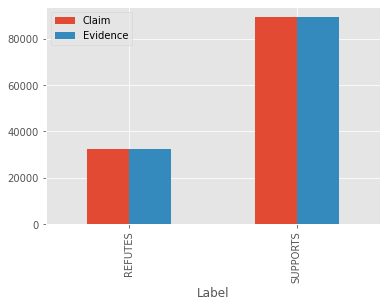

In [12]:
plt.figure(figsize=(10,10))
class_dist[['Claim', 'Evidence']].plot.bar()
plt.show()

<h3> transform the target class into binary digits 0 and 1 </h3>

In [13]:
train_labels = np.array(list(map(lambda x: 1 if x == 'SUPPORTS' else 0, labels)))
test_labels = np.array(list(map(lambda x: 1 if x == 'SUPPORTS' else 0, test_labels)))

In [14]:
# Convert pandas data structure into numpy
evidence = evidence.to_numpy()
claims = claims.to_numpy()

In [15]:
test_claims, test_evidence = test_claims.to_numpy(), test_evidence.to_numpy()

In [16]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type, embedding_dimension=50):
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
embedding_model_type = "glove"
embedding_dimension = 50

embedding_model = load_embedding_model(embedding_model_type, embedding_dimension)
        

[==================================================] 100.0% 66.0/66.0MB downloaded


<h3> Build embedding matrix for both Claims and Evidence </h3>

In [17]:
# Compute the embedding matrix
# for simplicity, Embedding vector for OOV are assumed to be zero
embedding_dim = 50
claim_uniq = set(flatten(Token(claims)))
claim_embedding_matrix = np.zeros((len(claim_uniq),embedding_dim), dtype=np.float32)
oov_terms = []
for i,word in enumerate(claim_uniq):
  if not word in embedding_model.vocab:
    oov_terms.append(word)
    claim_embedding_matrix[i] = np.random.rand(embedding_dim)
  else:
    claim_embedding_matrix[i] = embedding_model[word]


In [18]:
# Compute the embedding matrix
# for simplicity, Embedding vector for OOV are assumed to be zero
embedding_dim = 50
evidence_uniq = set(flatten(Token(evidence)))
evidence_embedding_matrix = np.zeros((len(evidence_uniq),embedding_dim), dtype=np.float32)
oov_terms = []
for i,word in enumerate(evidence_uniq):
  if not word in embedding_model.vocab:
    oov_terms.append(word)
    evidence_embedding_matrix[i] = np.random.rand(embedding_dim)
  else:
    evidence_embedding_matrix[i] = embedding_model[word]

<h3> <ol>Build a **vectorization layer** that transforms strings into indices</ol>
<ol> **Embedding layer** takes the integer-encoded vocabulary and looks up the embedding vector <br>for each word-index. These vectors are learned as the model trains</ol></h3>

In [19]:
max_token = 10000
claim_max_emb = claim_embedding_matrix.shape[0]
# Vectorization layer
vectorize_layer_claims = TextVectorization(max_tokens=claim_max_emb, output_sequence_length=192, name='claim_1')
vectorize_layer_claims.adapt(claims)
vocab = vectorize_layer_claims.get_vocabulary()
# Embedding layer
claim_embedding_layer = layers.Embedding(claim_embedding_matrix.shape[0],50, 
                            trainable=False, 
                            weights = [claim_embedding_matrix], name ="claim_2"
                             )

In [20]:
#max_token = 10000
evidence_max_emb = evidence_embedding_matrix.shape[0]
# Vectorization layer
vectorize_layer_evidence = TextVectorization(max_tokens=evidence_max_emb , output_sequence_length= 192, name='evidence_1')
vectorize_layer_evidence.adapt(evidence)
vocab_ev = vectorize_layer_evidence.get_vocabulary()
# Embedding Layer
evidence_embedding_layer = layers.Embedding(evidence_embedding_matrix.shape[0],50, 
                            trainable=False, 
                            weights = [evidence_embedding_matrix], name ="evidence_2"
                             )

<h2> Set batch size, number of epochs and set a callback </h2>

In [21]:
batch_size = 64
epochs = 150
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=5, restore_best_weights=True)

<h1> Define Baseline model </h1>

In [22]:
def baseline_gru_model():
  inp_claim = tf.keras.Input(shape=(1,), dtype=tf.string, name='claim_0')

  inp_evidence = tf.keras.Input(shape=(1,), dtype=tf.string, name='evidence_0')

  x_ev = vectorize_layer_evidence(inp_evidence)
  #x_ev = layers.Embedding(max_token, 128,  name='Evidence_Embedding_layer')(x_ev)
  x_ev = evidence_embedding_layer(x_ev)
  x_ev = layers.Bidirectional(layers.GRU(int(embedding_dim/2), return_sequences=True), name='evidence_3')(x_ev)
  x_ev = layers.Bidirectional(layers.GRU(int(embedding_dim/2)), name='evidence_4')(x_ev)
  



  x_c = vectorize_layer_claims(inp_claim)
  #x_c = layers.Embedding(max_token, 128, name='Claim_Embedding_layer')(x_c)
  x_c = claim_embedding_layer(x_c)
  x_c = layers.Bidirectional(layers.GRU(int(embedding_dim/2), return_sequences=True), name='claim_3')(x_c)
  x_c = layers.Bidirectional(layers.GRU(int(embedding_dim/2)), name='claim_4')(x_c)
  
 
  

  x = layers.Concatenate()([x_c, x_ev])
  x = layers.Dense(1024)(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model([inp_claim,inp_evidence], x)
  #model.summary()
  return model

<h2> Instantiation of the baseline model </h2 

In [23]:
baseline_model = baseline_gru_model()
#baseline_model.summary()

<h2> Compile the model </h2>

In [24]:
baseline_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])



<h2> Training the model </h2>

In [25]:
%%time
baselinehistory = baseline_model.fit([claims, evidence],train_labels,
                    epochs= epochs, 
                    batch_size= batch_size, 
                    validation_split=0.1, 
                    callbacks=[callbacks])

Epoch 1/150
1712/1712 [==============================] - 134s 69ms/step - loss: 0.5475 - accuracy: 0.7489 - val_loss: 0.4129 - val_accuracy: 0.8278
Epoch 2/150
1712/1712 [==============================] - 113s 66ms/step - loss: 0.4713 - accuracy: 0.7970 - val_loss: 0.3953 - val_accuracy: 0.8389
Epoch 3/150
1712/1712 [==============================] - 109s 64ms/step - loss: 0.4434 - accuracy: 0.8102 - val_loss: 0.3609 - val_accuracy: 0.8530
Epoch 4/150
1712/1712 [==============================] - 110s 64ms/step - loss: 0.4237 - accuracy: 0.8193 - val_loss: 0.3511 - val_accuracy: 0.8556
Epoch 5/150
1712/1712 [==============================] - 110s 64ms/step - loss: 0.4097 - accuracy: 0.8255 - val_loss: 0.3489 - val_accuracy: 0.8604
Epoch 6/150
1712/1712 [==============================] - 113s 66ms/step - loss: 0.3983 - accuracy: 0.8290 - val_loss: 0.3499 - val_accuracy: 0.8577
Epoch 7/150
1712/1712 [==============================] - 109s 64ms/step - loss: 0.3903 - accuracy: 0.8339 - val_

<p> Show plot of train and validation parameters:<br>loss<br>Accuracy<br>val_loss<br>val_acc</p>

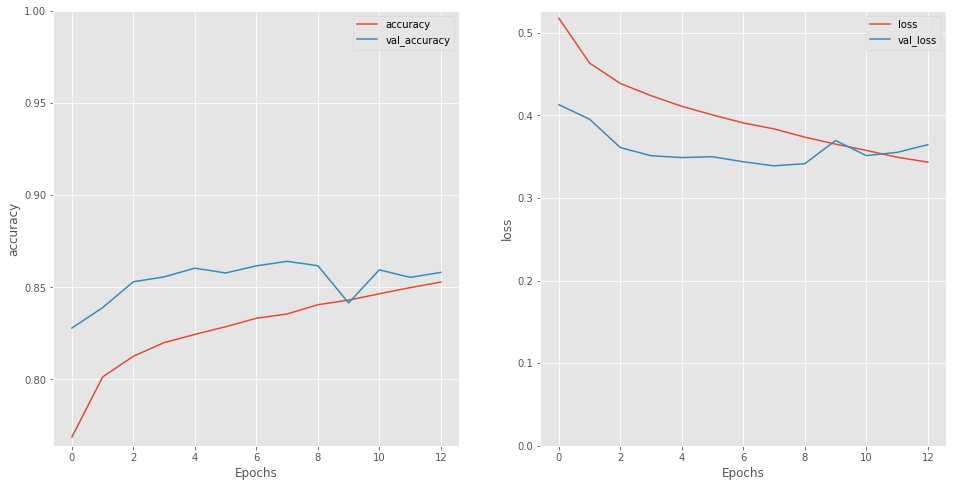

In [26]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(baselinehistory, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(baselinehistory, 'loss')
plt.ylim(0,None)
plt.savefig('baseline_model.png')

<h1> Build the extended model </h1>

In [27]:
def Gru_model_extension():
  inp_claim = tf.keras.Input(shape=(1,), dtype=tf.string, name='claim_0')

  inp_evidence = tf.keras.Input(shape=(1,), dtype=tf.string, name='evidence_0')

  

  x_ev = vectorize_layer_evidence(inp_evidence)
  #x_ev = layers.Embedding(max_token, 128,  name='Evidence_Embedding_layer')(x_ev)
  x_ev = evidence_embedding_layer(x_ev)
  x_ev = layers.Bidirectional(layers.GRU(int(embedding_dim/2), return_sequences=True), name='evidence_3')(x_ev)
  x_ev = layers.Bidirectional(layers.GRU(int(embedding_dim/2)), name='evidence_4')(x_ev)
  


  x_c = vectorize_layer_claims(inp_claim)
  #x_c = layers.Embedding(max_token, 128, name='Claim_Embedding_layer')(x_c)
  x_c = claim_embedding_layer(x_c)
  x_c = layers.Bidirectional(layers.GRU(int(embedding_dim/2), return_sequences=True), name='claim_3')(x_c)
  x_c = layers.Bidirectional(layers.GRU(int(embedding_dim/2)), name='claim_4')(x_c)


  sim_layer = layers.Dot(axes=1)([x_c, x_ev])
  n_ev = tf.norm(x_ev)
  n_c = tf.norm(x_c)
  sim_layer = tf.divide(sim_layer, tf.multiply(n_c, n_ev))
  
 
  

  x = layers.Concatenate()([x_c, x_ev, sim_layer])
  x = layers.Dense(1024)(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model([inp_claim,inp_evidence], x)
  return model

In [28]:
extension_gru_model = Gru_model_extension()
#extension_gru_model.summary()

In [29]:
#extension_gru_model.summary()

In [30]:
extension_gru_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [31]:
%%time
extension_gru_history = extension_gru_model.fit([claims, evidence],train_labels,
                    epochs= epochs, 
                    batch_size= batch_size, 
                    validation_split=0.1, 
                    callbacks=[callbacks])

Epoch 1/150
1712/1712 [==============================] - 116s 63ms/step - loss: 0.5428 - accuracy: 0.7542 - val_loss: 0.4196 - val_accuracy: 0.8281
Epoch 2/150
1712/1712 [==============================] - 105s 62ms/step - loss: 0.4639 - accuracy: 0.8018 - val_loss: 0.3861 - val_accuracy: 0.8475
Epoch 3/150
1712/1712 [==============================] - 104s 61ms/step - loss: 0.4424 - accuracy: 0.8115 - val_loss: 0.3634 - val_accuracy: 0.8537
Epoch 4/150
1712/1712 [==============================] - 105s 61ms/step - loss: 0.4259 - accuracy: 0.8190 - val_loss: 0.3626 - val_accuracy: 0.8551
Epoch 5/150
1712/1712 [==============================] - 105s 62ms/step - loss: 0.4094 - accuracy: 0.8252 - val_loss: 0.3505 - val_accuracy: 0.8592
Epoch 6/150
1712/1712 [==============================] - 104s 61ms/step - loss: 0.3990 - accuracy: 0.8286 - val_loss: 0.3504 - val_accuracy: 0.8569
Epoch 7/150
1712/1712 [==============================] - 104s 61ms/step - loss: 0.3907 - accuracy: 0.8309 - val_

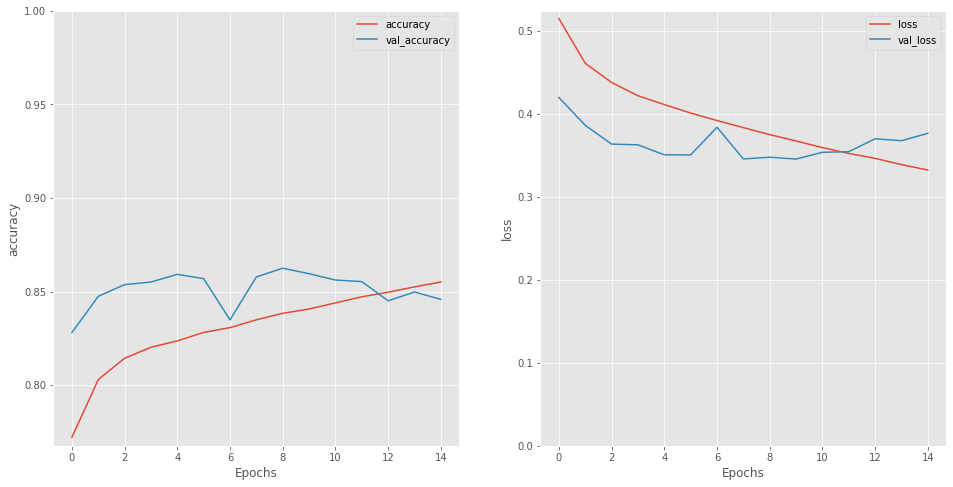

In [32]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(extension_gru_history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(extension_gru_history, 'loss')
plt.ylim(0,None)
plt.savefig ('extended_model.png')

<h4> Build pair (claim, evidence) checking but and then pick the best for majority voting evaluation </h4>

In [33]:
f1_score_macro = []
pred = np.vectorize(lambda x: 1 if x > 0.5 else 0)
best_model = ''
best_f1_score = 0.
names = ["baseline model", "Extension Model"]
list_models = [baseline_model, extension_gru_model]

for i, model in enumerate(list_models):
  y_pred = model.predict([test_claims, test_evidence])
  y_pred = pred(y_pred)
  f1 =f1_score(test_labels, y_pred, average='macro')
  print(f"{names[i]}...")
  print(classification_report(test_labels, y_pred))
  if best_f1_score < f1:
    best_f1_score = f1
    best_model = model
    best_model_name = names[i]
  print(f"f1 score for {names[i]} is {f1:.4f}")
  f1_score_macro.append(f1)
  print("="*100)

print("="*100)
print(f"The best model is the {best_model_name} with f1 score: {best_f1_score:.4f}")  

baseline model...
              precision    recall  f1-score   support

           0       0.88      0.39      0.54      3583
           1       0.61      0.95      0.74      3606

    accuracy                           0.67      7189
   macro avg       0.74      0.67      0.64      7189
weighted avg       0.74      0.67      0.64      7189

f1 score for baseline model is 0.6405
Extension Model...
              precision    recall  f1-score   support

           0       0.86      0.40      0.55      3583
           1       0.61      0.94      0.74      3606

    accuracy                           0.67      7189
   macro avg       0.74      0.67      0.64      7189
weighted avg       0.74      0.67      0.64      7189

f1 score for Extension Model is 0.6426
The best model is the Extension Model with f1 score: 0.6426


<h4> Build Majority voting algos </h4>

In [34]:
# vectorization function which transforms the prediction outputs in 0 and 1
f = np.vectorize(lambda x: 1 if x > 0.5 else 0)

def generate_labels(model, c, evidence):
  d = f(model.predict([np.full(len(evidence), c, dtype=np.object), evidence]).flatten())
  return 1 if np.count_nonzero(d==0) < np.count_nonzero(d==1) else 0

<p> For the sake of computational cost, we have decided to use 10 set of evidence</p>

In [ ]:
%%time
claims_checking = []

for i,c in enumerate(test_claims):
  lab = generate_labels(best_model, str(c), test_evidence[:100])
  claims_checking.append(lab)

  if i%1000==0:
    print(f"{i}-th True-claim: {'S' if test_labels[i]==1 else 'R'}  ---   Predicted-claim: {'S' if lab==1 else 'R'}")
print('Completed...')
print("="*100)
print(classification_report(np.array(claims_checking), test_labels))

0-th True-claim: S  ---   Predicted-claim: S
1000-th True-claim: R  ---   Predicted-claim: R


# Classification dataset

At this point, you should have a reay-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build (claim, evidence) pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

**Note**: The dataset requires some text cleaning as you may notice!


# Problem formulation

As mentioned at the beginning of the assignment, we are going to formulate the fact checking problem as a binary classification task.

In particular, each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences support or refute the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1 
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)

## Schema

The overall binary classification problem is summed up by the following (simplified) schema

![](https://drive.google.com/uc?export=view&id=1Wm_YBnFwgJtxcWEBpPbTBEVkpKaL08Jp)

Don't worry too much about the **Encoding** block for now. We'll give you some simple guidelines about its definition. For the moment, stick to the binary classification task definition where, in this case, we have 2 inputs: the claim to verify and one of its associated evidences.

# Architecture Guidelines

There are many neural architectures that follow the above schema. To avoid phenomena like the writer's block, in this section we are going to give you some implementation guidelines.

In particular, we would like you to test some implementations so that you explore basic approaches (neural baselines) and use them as building blocks for possible extensions.

## Handling multiple inputs

The first thing to notice is that we are in a multi-input scenario. In particular, each sample is comprised of a fact and its asssociated evidence statement.

Each of these input is encoded as a sequence of tokens. In particular, we will have the following input matrices:

*    Claim: [batch_size, max_tokens]
*    Evidence: [batch_size, max_tokens]

Moreover, after the embedding layer, we'll have:

*    Claim: [batch_size, max_tokens, embedding_dim]
*    Evidence: [batch_size, max_tokens, embedding_dim]

But, we would like to have a 2D input to our classifier, since we have to give an answer at pair level. Therefore, for each sample, we would expect the following input shape to our classification block:

*   Classification input shape: [batch_size, dim]

**How to do that?**

We inherently need to reduce the token sequence to a single representation. This operation is formally known as **sentence embedding**. Indeed, we are trying to compress the information of a whole sequence into a single embedding vector.

Here are some simple solutions that we ask you to try out:

*   Encode token sequences via a RNN and take the last state as the sentence embedding.

*   Encode token sequences via a RNN and average all the output states.

*   Encode token sequences via a simple MLP layer. In particular, if your input is a [batch_size, max_tokens, embedding_dim] tensor, the matrix multiplication works on the **max_tokens** dimension, resulting in a [batch_size, embedding_dim] 2D matrix.

*   Compute the sentence embedding as the mean of its token embeddings (**bag of vectors**).

## Merging multi-inputs

At this point, we have to think about **how** we should merge evidence and claim sentence embeddings.

For simplicity, we stick to simple merging strategies:

*     **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings

*     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings

*     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings

For clarity, if we the sentence embedding of a single input has shape [batch_size, embedding_dim], then the classification input has shape:

*     **Concatenation**: [batch_size, 2 * embedding_dim]

*     **Sum**: [batch_size, embedding_dim]

*     **Mean**: [batch_size, embedding_dim]

# A simple extension

Lastly, we ask you to modify previously defined neural architectures by adding an additional feature to the classification input.

We would like to see if some similarity information between the claim to verify and one of its associated evidence might be useful to the classification.

Compute the cosine similarity metric between the two sentence embeddings and concatenate the result to the classification input.

For clarity, since the cosine similarity of two vectors outputs a scalar value, the classification input shape is modified as follows:

*     **Concatenation**: [batch_size, 2 * embedding_dim + 1]

*     **Sum**: [batch_size, embedding_dim + 1]

*     **Mean**: [batch_size, embedding_dim + 1]



# Performance evaluation

Due to our simplifications, obtained results are not directly compatible with a traditional fact checking method that considers the evidence set as a whole.

Thus, we need to consider two types of evaluations.

**Multi-input classification evaluation**

This type of evaluation is the easiest and concerns computing evaluation metrics, such as accuracy, f1-score, recall and precision, of our pre-processed dataset.

In other words, we assess the performance of chosen classifiers.

**Claim verification evaluation**

However, if we want to give an answer concerning the claim itself, we need to consider the whole evidence set. 

Intuitively, for a given claim, we consider all its corresponding (claim, evidence) pairs and their corresponding classification outputs. 

At this point, all we need to do is to compute the final predicted claim label via majority voting.

Example:

    Claim: c1
    Evidence set: e1, e2, e3
    True label: S

    Pair outputs:
    (c1, e1) -> S (supports)
    (c1, e2) -> S (supports)
    (c1, e3) -> R (refutes)

    Majority voting:
    S -> 2 votes
    R -> 1 vote

    Final label:
    c1 -> S

Lastly, we have to compute classification metrics just like before.

# Tips and Extras

## Extensions are welcome!

Is this task too easy for you? Are you curious to try out things you have seen during lectures (e.g. attention)? Feel free to try everything you want!

Don't forget to try neural baselines first!

## Comments and documentation

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

## Organization

We suggest you to divide your work into sections. This allows you to build clean and modular code, as well as easy to read and to debug.

A possible schema:

*   Dataset pre-processing
*   Dataset conversion
*   Model definition
*   Training
*   Evaluation
*   Comments/Summary

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

Don't forget that your feedback is very important! Your suggestions help us improving course material.

# FAQ

---

**Q: Can I do something text pre-processing?**

**A:** You have to! If you check text data, the majority of sentences need some cleaning.

---

**Q: I'm struggling with the implementation. Can you help me?**

**A:** Yes sure! Write us an email about your issue. If you are looking for a particular type of operation, you can easily check the documentation of the deep learning framework you are using (google is your friend).

---

**Q: Can I try other encoding strategies or neural architectures?**

**A:** Absolutely! Remember to try out recommended neural baselines first and only then proceed with your extensions.

---